# About
A company would like to gain insight about the price offerings of products on the market. During processing of offers for products, each offer needs to be matched to a product in a database. Here two datasets are provided: one representing a product database and one representing the offer stream. The task is to match each offer to a product. The products considered here belong to the category of cell phones.

## Problem approach 
I consider this a classification task, where the each offer is considered as input that should be mapped to a single product. Since there are many products, it's a multiclass problem. 

The modeling is assumed to be complementary to the [GTIN](https://en.wikipedia.org/wiki/Global_Trade_Item_Number) index mapping, so I don't use that as an input feature. For a first prototype I use only the offer data to map to a product, i.e. without interacting with the product database. This means that I don't actually make use of the product attributes.

#  Imports, setup

In [1]:
# General
import os
import sys
from tqdm import tqdm
from time import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

In [2]:
sns.set_style("whitegrid")

In [3]:
# Transformers, data
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from scipy import sparse

In [4]:
# Hyperparameter search and cross-validation
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.utils.fixes import loguniform
from scipy.stats import randint
from scipy.stats import uniform

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
# from sklearn.svm import LinearSVC
# see https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification

# Load and merge datasets

In [6]:
products_filepath = "product_database.json"
offers_filepath = "./offers.json"

In [7]:
df_products = pd.read_json(products_filepath)
df_offers = pd.read_json(offers_filepath)

## Products data

In [8]:
df_products

,id,categoryId,combinedNames,productNames,positivelyVerifiedOfferNames,attributes,gtin14,isbn10,priceCalculations
0,4333574,1,"[primux omega 7 dual sim, mobile telephone pri...",[primux omega 7 dual sim],[{'offerId': '102774_6671-mobile-telephone-pri...,"[{'id': '25639', 'values': ['flash/light', 'au...",[08433735004678],[],"{'mean': 154.0, 'median': 154.0, 'standardDevi..."
1,5034558,1,"[cubot j7 dual sim 16gb 2gb ram sort, cubot j7...",[cubot j7 16gb dual sim],"[{'offerId': '107077_KNA-TEL-704329', 'name': ...","[{'id': '25639', 'values': ['flash/light', 'au...","[06924136707005, 06924136707012, 06924136707029]",[],"{'mean': 84.95375, 'median': 88.67, 'standardD..."
2,3223792,1,"[zte blade v7 dual sim, zte blade v7 grey 5.2""...",[zte blade v7 dual sim],"[{'offerId': '103116_1314758', 'name': 'zte bl...","[{'id': '25639', 'values': ['flash/light', 'au...",[],[],"{'mean': 100.85, 'median': 100.85, 'standardDe..."
3,3968527,1,"[apple iphone 6 32gb - space grey, apple iphon...",[apple iphone 6 32gb],"[{'offerId': '58986_IN246', 'name': 'apple iph...","[{'id': '25639', 'values': ['optisk bildstabil...","[00190198429117, 00190198429308, 0019019842909...",[],"{'mean': 521.7725, 'median': 378.59, 'standard..."
4,5020515,1,"[mobile phone bv6100/grey blackview, blackview...",[blackview bv6100 16gb dual sim],[{'offerId': '103631_9416-blackview-bv6100-3gb...,"[{'id': '25639', 'values': ['flash/light', 'au...",[06931548305866],[],"{'mean': 226.52666666666667, 'median': 210.9, ..."
...,...,...,...,...,...,...,...,...,...
1882,4346306,1,"[ulefone mix dual sim, ulefone mix 4g phablet,...",[ulefone mix dual sim],"[{'offerId': '70891_229068401', 'name': 'ulefo...","[{'id': '25639', 'values': ['flash/light', 'au...",[06937748731412],[],"{'mean': 131.19, 'median': 93.68, 'standardDev..."
1883,4282088,1,"[elephone p8 mini 4g smartphone, elephone p8 m...",[elephone p8 mini dual sim],"[{'offerId': '70891_213230702', 'name': 'eleph...","[{'id': '25639', 'values': ['flash/light', 'au...",[00730060570075],[],"{'mean': 196.17000000000002, 'median': 196.170..."
1884,4497822,1,[xiaomi redmi 5a 16gb dual sim],[xiaomi redmi 5a 16gb dual sim],[],"[{'id': '25639', 'values': ['flash/light', 'au...",[06954176839343],[],None
1885,3495282,1,[cubot echo dual sim],[cubot echo dual sim],[],"[{'id': '3914', 'values': ['smartphone', 'vanl...",[],[],None


Feature description and comments:
* `id`: unique identifier for each database entry, this will be used as the classification target.
* `categoryId`: always equal to 1 (corresponds to "Mobiltelefoner"). Not useful here.
* `combinedNames`: lists of strings describing the product. This appears to be the union of the product names and all the associated offers (`positivelyVerifiedOfferNames`).
* `productNames`: a list of names, can be more than one.
* `positivelyVerifiedOfferNames`: these are the offers associated with these products, which I'll use to connect an offer to a product.
* `attributes`: list of product attributes, each with an id, values and units.
* `gtin14`: an id for the product (Global Trade Item Number). Some products in the dataset have more than one id, although it's rare.
* `isbn10`: here always an empty list and does in any case not apply for this category.
* `priceCalculations`: Price statistics for fot the associated offers (listed in `positivelyVerifiedOfferNames`).

## Offers data

In [9]:
df_offers

,offerId,name,description,gtin14,isbn10,priceAmount,lastUpdated
0,106396_samsung-galaxy-a8s-g8870-128gb-6gbram-d...,samsung galaxy a8s g8870 128gb 6gb(ram) (dual ...,network technology gsm / hspa / lte body dimen...,NaN,NaN,534.98,2019-09-13T09:02:20.777+02:00
1,101551_15530-xiaomi-pocophone-f1-global-versio...,xiaomi pocophone f1 global version 6.18 inch 6...,None,NaN,NaN,309.99,2019-09-13T07:35:37.408+02:00
2,103035_sony-xperia-z3-plus-e6553-32gb-white,sony xperia z3 plus e6553 32gb (white),productdesc sony xperia z3 plus rows what's in...,NaN,NaN,764.66,2019-09-13T09:00:06.164+02:00
3,99829_xiaomi-mi-a2-lite-64gb-dual-sim-unlocked...,xiaomi mi a2 lite 64gb dual sim / unlocked - b...,the xiaomi mi a2 lite is an unlocked dual sim ...,NaN,NaN,206.98,2019-09-13T05:49:35.296+02:00
4,100405_5717,xiaomi mi 9 6gb/128gb dual sim sim free/ unloc...,xiaomi mi 9 super-fast snapdragon™ 855with two...,6.941060e+12,NaN,389.99,2019-09-13T00:19:05.623+02:00
...,...,...,...,...,...,...,...
20002,2137_B07RYLXX71,samsung galaxy a10 dual-sim 32gb 6.2-inch hd+ ...,samsung galaxy a10 black,8.801644e+12,NaN,155.64,2019-09-13T04:27:32.433+02:00
20003,107077_KNA-TEL-704247,xiaomi redmi 7a 4g 16gb dual-sim morning blue,"accelerometer, proximity, compass; fast batter...",6.941060e+12,NaN,105.36,2019-09-13T04:30:12.537+02:00
20004,105100_xiaomi-mi-a3-64gb-dual-sim-unlocked-blue,xiaomi mi a3 64gb dual sim / unlocked - blue,"64gb internal storage, 4gb ram condition: new....",NaN,NaN,264.98,2019-09-13T03:30:55.726+02:00
20005,83959_3398500,nokia 216 dual sim - mobiltelefon - dual-sim -...,kurzinfo: nokia 216 dual sim - mobiltelefon - ...,6.438159e+12,NaN,53.91,2019-09-12T15:22:00.225+02:00


Feature description and comments:
* `offerId`: uniquely identifies an offer, merchant specific.
* `name`: the name of the offer, which is often quite information-dense and specific for each product.
* `description`: a description about the offer/product, usally some more lengthy or "selling" information about the product but many are `None` and also there are diferent languages (English, Spanish, German, etc). 
* `gtin14`: same variable as in the product database, although here it is often null.
* `isbn10`: same as for the products.
* `priceAmount`: the price for the product the offer is about. Competitors will through market forces provide similar offers for similar products and so this should be useful for matchint to the right product.  
* `lastUpdated`: this doesn't say anything about the product the offer is about and I won't make use of it here.

In [10]:
df_offers.isna().sum()

offerId            0
name               0
description     5848
gtin14         11964
isbn10         20007
priceAmount        0
lastUpdated        0
dtype: int64

Some observations about missing values:
* ~29% of `descriptions` have `None` value. These can be replace by empty string.
* All `isbn10` are NaN. This is not relevant for this category and can be dropped.
* ~60% of `gtin14` is NaN. The remaining ones are large integer numbers.

## Other observations about the datasets
To understand the data better I've performed some checks (not shown).
The following statemtents seem to hold:

* Some verifed offers (referred to in the product dataset) are not found in the offer dataset. 
* Sometimes the verified offer are not found in the offer dataset.
* Some offers are not referred to by any product.
* Some products refer to unknown offers.
    * Sometimes offer ids are not known, even thought the name is known.
    * Sometimes neither the offer id or the name is known.
* Some products refer to no offers (empty list).
* GTIN ids listed in product dataset are not always found in the offer dataset.
* Offer ids are unique but offer names are not unique.

# Data prep

## Encode target
I use the internal product id as target, i.e. category labels. These are unique. Instead of the given id's I use consecutive integers.

In [11]:
le = preprocessing.LabelEncoder()
le.fit(df_products.id)

LabelEncoder()

In [14]:
df_products['target'] = le.transform(df_products.id)

In [16]:
df_products['target'].values

array([1027, 1881,  649, ..., 1184,  738, 1109])

## Associate offers to products
I use the product id in `df_products` as the prediction target based on features of each offer in `df_offer`.  Offers and features are  linked by the `positivelyVerifiedOfferNames`, which I take as the ground truth. Here, I map each offer to a target (product id) by expanding this dictionary and joining the two dataframes on the `offerId`. 

Note that this is not always possible, all products don't have offers, and I'll  drop those data points. This also means that some products are never "seen" by the model and so will/should never be matched to an offer. Clustering the products into subcategories could be one way that a more refined modeling approach could make sure that all products are connected to a set of offers.  

In [80]:
# Flatten the product info by turning each associated offer into a new record/row.
# Each row will now have a single dictionary item.
df_products_flat = df_products.explode('positivelyVerifiedOfferNames')

In [81]:
df_products_flat['positivelyVerifiedOfferNames'].iloc[0]

{'offerId': '102774_6671-mobile-telephone-primux-omega-7-5-5-4g-16-gb-quad-core-8433735004678',
 'name': 'mobile telephone primux omega 7 5.5" 4g 16 gb quad core'}

In [82]:
# Drop products that don't have positively verified offers (explode([]) --> NaN)
df_products_flat = df_products_flat[~df_products_flat['positivelyVerifiedOfferNames'].isna()]

In [83]:
# Replace `positivelyVerifiedOfferNames with `offerId` and `name` (key and value of the single-item dict).
new_cols = pd.json_normalize(df_products_flat['positivelyVerifiedOfferNames']).set_index(df_products_flat.index.copy())
df_products_flat = pd.concat([df_products_flat.drop(columns='positivelyVerifiedOfferNames'), new_cols], axis=1)

In [85]:
# Merge with offers
df_merged = df_offers.merge(df_products_flat, on='offerId', how='inner', suffixes=('', '_y'))

In [88]:
df_merged

,offerId,name,description,gtin14,isbn10,priceAmount,lastUpdated,id,categoryId,combinedNames,productNames,attributes,gtin14_y,isbn10_y,priceCalculations,target,name_y
0,106396_samsung-galaxy-a8s-g8870-128gb-6gbram-d...,samsung galaxy a8s g8870 128gb 6gb(ram) (dual ...,network technology gsm / hspa / lte body dimen...,NaN,NaN,534.98,2019-09-13T09:02:20.777+02:00,4851556,1,[samsung galaxy a8s g8870 128gb 6gb(ram) (dual...,[samsung galaxy a8s 6gb ram 128gb dual sim],"[{'id': '25639', 'values': ['flash/light', 'au...",[08801643718763],[],"{'mean': 464.014, 'median': 464.81, 'standardD...",1714,samsung galaxy a8s g8870 128gb 6gb(ram) (dual ...
1,101551_15530-xiaomi-pocophone-f1-global-versio...,xiaomi pocophone f1 global version 6.18 inch 6...,None,NaN,NaN,309.99,2019-09-13T07:35:37.408+02:00,4689772,1,[xiaomi pocophone f1 6gb/128gb dual sim sim fr...,[xiaomi pocophone f1 128gb dual sim],"[{'id': '25639', 'values': ['flash/light', 'au...","[06941059617648, 06941059607885, 0694105960787...",[],"{'mean': 362.30105263157895, 'median': 345.75,...",1446,xiaomi pocophone f1 global version 6.18 inch 6...
2,103035_sony-xperia-z3-plus-e6553-32gb-white,sony xperia z3 plus e6553 32gb (white),productdesc sony xperia z3 plus rows what's in...,NaN,NaN,764.66,2019-09-13T09:00:06.164+02:00,3069514,1,"[sony xperia z3 plus e6553 32gb (white), sony ...",[sony xperia z3+ 32gb],"[{'id': '5056', 'values': ['android'], 'units'...","[07311271523444, 07311271515128, 0731127152553...",[],"{'mean': 646.56, 'median': 764.66, 'standardDe...",459,sony xperia z3 plus e6553 32gb (white)
3,99829_xiaomi-mi-a2-lite-64gb-dual-sim-unlocked...,xiaomi mi a2 lite 64gb dual sim / unlocked - b...,the xiaomi mi a2 lite is an unlocked dual sim ...,NaN,NaN,206.98,2019-09-13T05:49:35.296+02:00,4675215,1,[xiaomi mi a2 lite 4/64gb lte /4g dual-sim and...,[xiaomi mi a2 lite 64gb dual sim],"[{'id': '25639', 'values': ['flash/light', 'au...","[07441319035001, 06941059608677, 0694105960865...",[],"{'mean': 185.87297872340426, 'median': 177.66,...",1398,xiaomi mi a2 lite 64gb dual sim / unlocked - b...
4,100405_5717,xiaomi mi 9 6gb/128gb dual sim sim free/ unloc...,xiaomi mi 9 super-fast snapdragon™ 855with two...,6.941060e+12,NaN,389.99,2019-09-13T00:19:05.623+02:00,4852906,1,"[xiaomi mi 9 4g 128gb dual sim negro, xiaomi m...",[xiaomi mi 9 6gb ram 128gb dual sim],"[{'id': '25639', 'values': ['flash/light', 'au...","[06941059621348, 06941059619420, 0694105961947...",[],"{'mean': 484.1327027027027, 'median': 487.665,...",1720,xiaomi mi 9 6gb/128gb dual sim sim free/ unloc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17988,2137_B07RYLXX71,samsung galaxy a10 dual-sim 32gb 6.2-inch hd+ ...,samsung galaxy a10 black,8.801644e+12,NaN,155.64,2019-09-13T04:27:32.433+02:00,4889492,1,"[samsung galaxy a10 sm-a105 dual blue, samsung...",[samsung galaxy a10 32gb dual sim],"[{'id': '25639', 'values': ['flash/light'], 'u...","[08806090016561, 08801643996642, 0571276401827...",[],"{'mean': 175.64909090909092, 'median': 169.77,...",1766,samsung galaxy a10 dual-sim 32gb 6.2-inch hd+ ...
17989,107077_KNA-TEL-704247,xiaomi redmi 7a 4g 16gb dual-sim morning blue,"accelerometer, proximity, compass; fast batter...",6.941060e+12,NaN,105.36,2019-09-13T04:30:12.537+02:00,4973455,1,[mobile phone redmi 7a 16gb/matte blue mzb7805...,[xiaomi redmi 7a 16gb dual sim],"[{'id': '25639', 'values': ['flash/light', 'au...","[06941059625612, 06941059625629, 06941059625926]",[],"{'mean': 105.5075, 'median': 105.03, 'standard...",1833,xiaomi redmi 7a 4g 16gb dual-sim morning blue
17990,105100_xiaomi-mi-a3-64gb-dual-sim-unlocked-blue,xiaomi mi a3 64gb dual sim / unlocked - blue,"64gb internal storage, 4gb ram condition: new....",NaN,NaN,264.98,2019-09-13T03:30:55.726+02:00,4996801,1,"[xiaomi mi a3 dual sim 64gb 4gb ram blue, xiao...",[xiaomi mi a3 64gb dual sim],"[{'id': '25639', 'values': ['optisk bildstabil...","[00649615757086, 06941059626329, 0694105962633...",[],"{'mean': 222.0964285714286, 

Two things to note: 
* Some products map to the same offer, meaning that the offer cannot be mapped uniquely to a single product. This is not a big problem, it can be seen as noise. Here, I'll consider this as multiple data points (one per product to offer connection).
* Some offers are not mapped to by any product, offers with name *xiaomi mi band 3*. This means that either 1) the product is missing in the database which should be update or 2) the product is in the database but is not "positively verified". Here, these datapoints were dropped since I used the using "inner"-type join operator when merging the dataframes.

The first point can be seen verified by checking the non-uniqueness of the `offerId` values:

In [177]:
df_merged['offerId'].value_counts()

535_0007753824-00000001                                                                    2
79225_51093RTS                                                                             2
84301_samsung-galaxy-s9-enterprise-edition-mobiltelefon-64-gb-schwarz-14-7-cm-p-1985967    2
83959_4139207                                                                              2
15001_5011126745                                                                           2
                                                                                          ..
35066_YP520                                                                                1
74931_B07NQVY729                                                                           1
40076_2791812                                                                              1
107077_KNA-TEL-703925                                                                      1
7539_23417542679                                                      

## Train test split check
For the multi-class modeling it's relevant how the different classes (product ids) are divided between the training and the test set. Since there are many classes with few samples per class, I expect this potentially be an issue.

In [134]:
X = df_merged
y = df_merged['target']

In [135]:
# 30% test is chosen arbitrarily here. 
split_args = dict(test_size=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, **split_args)

In [136]:
# Number of categories in train, test data
len(set(y))

1115

In [106]:
# Number of train samples and number of categories in data
len(y_train), len(set(y_train))

(12595, 1039)

In [107]:
# Number of test samples and number of categories in data
len(y_test), len(set(y_test))

(5398, 796)

In [108]:
# Number of products that are both in train and test set
len(set.intersection(set(y_test), set(y_train)))

720

In [109]:
# Number of products that are in test set but not in train set
len(set.intersection(set(y_test) - set(y_train)))

76

In [110]:
# Number of products that are in train set but not tested
len(set.intersection(set(y_train) - set(y_test)))

319

Based on the above checks we see that there are definitely problematic cases where a product is only in the test or train set. There are 1115 final products/classes.
* 76 classes are only in the test set (7%)
* 319 classes are only in the training set (29%)
* 720 classes are in both test and training (65%)

The fact that 29% of classes are not represented in the test set is pretty bad. This could give an unfair view on the model performance. Nonetheless, *most* classes are represented both in the test and the training and we carry on, at least to get a first baseline model to improve on.

## Conversions and imputations

In [117]:
# String types
for col in 'name', 'description':
    df_merged[col] = df_merged[col].astype('string')

In [118]:
# Replace `None` with empty string
df_merged['description'].fillna('', inplace=True)

# Model and hyperparameter search
Here I search over models, the model hyperparameters and different input features.

## Cross-validation config

In [119]:
# Cross-validation config
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)

In [120]:
scoring = 'accuracy'
assert scoring in sklearn.metrics.SCORERS.keys()

## Vary models
I consider 3 different classification models:
* K-nearest neighbors
* Multinomial Naive Bayes
* Linear SVM

and vary hyperparameters.

In [121]:
models = {
    'knn': KNeighborsClassifier,
    'naive-bayes': MultinomialNB, 
    'linear-svm': SGDClassifier,
}
# Fixed params
params_fixed = {
    'knn' : dict(),
    # Note: loss = 'log' would give logistic regression
    'linear-svm': dict(random_state=0, loss='hinge', max_iter=10, tol=None), 
    'naive-bayes': dict()
}
# Params to sample
params = {
    'linear-svm': {'penalty': ('l1', 'l2'),
            'alpha':  loguniform(1e-4, 1e-1),
            'class_weight': (None, 'balanced')},
    'knn': {'n_neighbors': randint(1,50),
            'weights': ('uniform', 'distance')},
    'naive-bayes': {'alpha':  loguniform(1e-2, 1e1)}
}

In [131]:
X

,name
0,samsung galaxy a8s g8870 128gb 6gb(ram) (dual ...
1,xiaomi pocophone f1 global version 6.18 inch 6...
2,sony xperia z3 plus e6553 32gb (white)
3,xiaomi mi a2 lite 64gb dual sim / unlocked - b...
4,xiaomi mi 9 6gb/128gb dual sim sim free/ unloc...
...,...
17988,samsung galaxy a10 dual-sim 32gb 6.2-inch hd+ ...
17989,xiaomi redmi 7a 4g 16gb dual-sim morning blue
17990,xiaomi mi a3 64gb dual sim / unlocked - blue
17991,nokia 216 dual sim - mobiltelefon - dual-sim -...


## Vary features

**Text features**: The offer `name` can be featurized and used for predicting the product. Similarly `description` could be used. However, `offer` looks more specific and promising for modeling and is also always avaialable while `description` is often missing.

I normalize using [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). The TF term sets the importance of the word relative to the document (offer) and the IDF term sets the importance of the word for the whole corpus (all offers). For instance *sim* may be relatively important in the offer name but less important when considering also other offer names. The feature values are now floating point weights, not integer counts.

**Numerical features**: The only numerical feature is `priceAmount` which I normalize with min-max scaling.


I consider the features by themselves and in combination. For combining, here I simply concatenate the features coming from each data variable (this could be improved on).

In [137]:
def get_transformed_features(features):
    # Transform each column separately
    Xs = []
    for col in features:
        cols = [col]
        dtype = X[col].dtype
        if dtype == 'string':
            Xs.append(transform_text(X_train[cols], X_test[cols]))
        elif dtype == 'float':
            Xs.append(transform_numerical(X_train[cols], X_test[cols]))
        else:
            raise ValueError(f"Unkown dtype {dtype}")

    X_train_transf, X_test_transf = zip(*Xs)

    # Concatenate
    try:
        X_train_transf = sparse.hstack(X_train_transf).tocsr()
        X_test_transf = sparse.hstack(X_test_transf).tocsr()
    except ValueError:
        X_train_transf = np.hstack(X_train_transf)
        X_test_transf = np.hstack(X_test_transf)

    return X_train_transf, X_test_transf

In [138]:
def transform_numerical(X_train, X_test):
    x_scaler = MinMaxScaler().fit(X_train)
    X_train_transf = x_scaler.transform(X_train)
    X_test_transf = x_scaler.transform(X_test)
    return X_train_transf, X_test_transf

In [139]:
def transform_text(X_train, X_test):
    vectorizer = CountVectorizer()
    X_train_transf = vectorizer.fit_transform(X_train.to_numpy().ravel())
    tfidf_transformer = TfidfTransformer()
    X_train_transf = tfidf_transformer.fit_transform(X_train_transf)
    X_test_transf = tfidf_transformer.transform(vectorizer.transform(X_test.to_numpy().ravel()))
    return X_train_transf, X_test_transf

In [140]:
# Dict of input features
Xs = {}
# The cols used for each feature combination
Xs_cols = {}

In [141]:
def add_features(features):
    name = '-'.join(features)
    print("adding", features, name)
    Xs_cols[name] = features
    Xs[name] = get_transformed_features(features)

In [142]:
# Generate the combinations
feature_candidates = ['priceAmount', 'name', 'description']

# Singles
for name in feature_candidates:
    add_features([name])

# Pairs
for i, name1 in enumerate(feature_candidates):
    for name2 in feature_candidates[i:]:
        if name2 == name1:
            continue
        add_features([name1, name2])
        
# All
# Skip for now
add_features(feature_candidates)

adding ['priceAmount'] priceAmount
adding ['name'] name
adding ['description'] description
adding ['priceAmount', 'name'] priceAmount-name
adding ['priceAmount', 'description'] priceAmount-description
adding ['name', 'description'] name-description
adding ['priceAmount', 'name', 'description'] priceAmount-name-description


## Test

I check the "worst-case" candidate roughly how long cross-validation takes, to see if the search is feasible. For this I pick the largest-dimensional feature space combined with the SVM model.

In [143]:
X_train_transf, X_test_transf = Xs['priceAmount-name-description']

In [144]:
X_train_transf

<12595x28909 sparse matrix of type '<class 'numpy.float64'>'
	with 861667 stored elements in Compressed Sparse Row format>

In [145]:
model_name = 'linear-svm'
clf = models[model_name](**params_fixed[model_name])

In [146]:
params_fixed[model_name]

{'random_state': 0, 'loss': 'hinge', 'max_iter': 10, 'tol': None}

In [149]:
n_iter = 1
search = RandomizedSearchCV(clf, param_distributions=params[model_name],
                            scoring=scoring, cv=cv, verbose=1, random_state=0, n_iter=n_iter)

with warnings.catch_warnings():
    t0 = time()
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    result = search.fit(X_train_transf, y_train.ravel())
    print(time() - t0)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
218.198637008667


In [150]:
# In minutes
218/60

3.6333333333333333

In [152]:
# Number of combinations * time in hours
len(Xs)*len(models)*(218/3600)

1.2716666666666667

For only a single hyperparameter sample per combination of model and feature, the cross-validation will take 1.3 h. For say, 10 samples this is almost 13 h which are more hours than my workday... To shorten the iteration time I remove some combinations manually.

## Remove some combinations

To shorten the search time for a first check, remove some combinations (the very high-dimensional ones which also take longer to fit for).

In [154]:
Xs.keys()

dict_keys(['priceAmount', 'name', 'description', 'priceAmount-name', 'priceAmount-description', 'name-description', 'priceAmount-name-description'])

In [155]:
del Xs['priceAmount-name-description']
del Xs['name-description']

In [156]:
print(Xs.keys())

dict_keys(['priceAmount', 'name', 'description', 'priceAmount-name', 'priceAmount-description'])


## Perform the search

In [158]:
search_results = {}
n_iter = 10
for x_name, (X_train_transf, X_test_transf)  in Xs.items():
    for model_name, model_cls in models.items():
        clf = model_cls(**params_fixed[model_name])
        key = (model_name, x_name)
        print(key)
        search = RandomizedSearchCV(clf, param_distributions=params[model_name],
                                    scoring=scoring, cv=cv, verbose=1, random_state=0, n_iter=n_iter)
        # Ignore warnings from combinations that don't converge
        with warnings.catch_warnings():
            t0 = time()
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            search_results[key] = search.fit(X_train_transf, y_train.ravel())
            print(time() - t0)

('knn', 'priceAmount')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
5.762128114700317
('naive-bayes', 'priceAmount')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
5.950376749038696
('linear-svm', 'priceAmount')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
151.64012718200684
('knn', 'name')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
41.78120803833008
('naive-bayes', 'name')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
11.171648979187012
('linear-svm', 'name')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
326.25977516174316
('knn', 'description')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
51.10265493392944
('naive-bayes', 'description')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
91.68438196182251
('linear-svm', 'description')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
1293.6771221160889
('knn', 'priceAmount-name')
Fitting 5 folds for each o

In [161]:
# Took about 21 min
1257/60

20.95

# Results

In [159]:
def top_results(search_results):
    """Return the best result of each search.
    
    Returns sorted dict, highest scoring first.
    """
    # TODO; is a bit messy here.
    best_results = dict()
    for name, search in search_results.items():
        means, stds, params = [search.cv_results_[x] for x in ('mean_test_score', 'std_test_score', 'params')]
        means_stds_params_sorted = sorted(zip(means, stds, params), key=(lambda t: t[0]), reverse=True)
        first = means_stds_params_sorted[0]
        mean, std, params = first
        best_results[name] = mean, std, params
    best_results = dict(sorted(best_results.items(), key=lambda x: x[1][0], reverse=True))
    return best_results

In [160]:
best_results = top_results(search_results)

In [162]:
best_results

{('linear-svm', 'priceAmount-name'): (0.780547836443033,
  0.007788962901742434,
  {'alpha': 0.0001149887074711945,
   'class_weight': 'balanced',
   'penalty': 'l2'}),
 ('linear-svm', 'name'): (0.7803096466851926,
  0.008963730386600532,
  {'alpha': 0.0001149887074711945,
   'class_weight': 'balanced',
   'penalty': 'l2'}),
 ('knn', 'priceAmount-name'): (0.7463279078999603,
  0.008621021550228118,
  {'n_neighbors': 4, 'weights': 'distance'}),
 ('knn', 'name'): (0.7395791980944819,
  0.007375767630007848,
  {'n_neighbors': 4, 'weights': 'distance'}),
 ('naive-bayes', 'name'): (0.6019055180627232,
  0.014586948551589523,
  {'alpha': 0.14135935551752296}),
 ('naive-bayes', 'priceAmount-name'): (0.5991266375545851,
  0.0140475874900176,
  {'alpha': 0.14135935551752296}),
 ('knn', 'priceAmount-description'): (0.5109170305676857,
  0.011107011997849038,
  {'n_neighbors': 1, 'weights': 'distance'}),
 ('knn', 'description'): (0.3473600635172688,
  0.008081308868598315,
  {'n_neighbors': 1, 'w

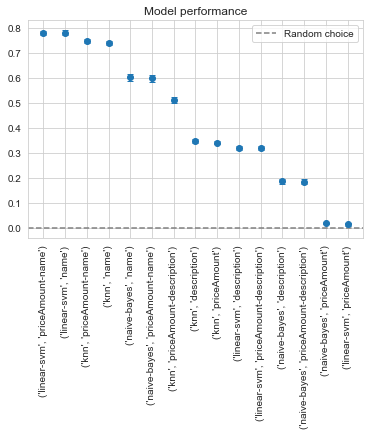

In [163]:
# Plot the best results
# Pick the simplest model as baseline
# TODO: could rotate this plot.

# Use as a very low-bar baseline the accuracy of picking the right one category in the training set at random.
baseline_val = 1/len(y_train.unique())
if baseline_val:
    plt.axhline(baseline_val, linestyle='--', color='gray', linewidth=1.5, label="Random choice")
    plt.legend()
labels=[]
for i, label in enumerate(best_results):
    mae, std = best_results[label][:2]
    plt.errorbar(i, mae, yerr=std, color='C0', marker='o', capsize=3)
    labels.append(label)
plt.xticks(np.arange(len(labels)), labels, rotation=90);
plt.ylabel('');
plt.title("Model performance");

Some observations:
* As expected, the name is the most predictive, followed by the description and price (which are comparable as single predictors).
* Linear SVM is the highest performing.
* Adding the price to a text feature barely does anything; the two highest performing `(linear-svm, priceAmount-name)` and `(linear-svm, name)` are essentialy the same.

## Evaluate best model

In [164]:
first = list(best_results)[0]
best_params = best_results[first][-1]
model_name, x_name = first
print(model_name, x_name, best_params)

linear-svm priceAmount-name {'alpha': 0.0001149887074711945, 'class_weight': 'balanced', 'penalty': 'l2'}


In [165]:
clf = models[model_name](**params_fixed[model_name], **best_params)
print(clf)

SGDClassifier(alpha=0.0001149887074711945, class_weight='balanced', max_iter=10,
              random_state=0, tol=None)


In [166]:
X_train_transf, X_test_transf = Xs[x_name]

In [167]:
clf.fit(X_train_transf, y_train)

SGDClassifier(alpha=0.0001149887074711945, class_weight='balanced', max_iter=10,
              random_state=0, tol=None)

In [168]:
y_pred = clf.predict(X_test_transf)
score = metrics.accuracy_score(y_test, y_pred)

In [169]:
# Test score
score

0.7932567617636161

# Conclusions

- Classification models were evaluated to predict which product and offer is for, given information about the offer.
- A search over model types with hyperparameters and input features was carried out using a randomized search. Accuracy was used as a scoring metric.
- **Result:** the best scoring model was linear SVM with using the offer `name` feature combined with `priceAmount`, with a test accuracy of 0.79. Including `name` only yielded similar performance.

## Next steps
The current solution has several weaknesses could be improved upon.
* Here numerical feature is simply appended to the text features, which might not be the best, especially when the number of text features is large. For instance one may want to apply neural network embeddings on the text features to reduce the dimensionality and then possibly apply more sophisticade NLP sequence models (LSTM, BERT) before merging the text output with the numerical feaures. A more simplistic way of achieving dimensionality reduction is to select the most "important" text features (words) for instance using Chi2 or frequency as metric.
* Similarly, there are alternative ways of combining two text source (here `description`, `name`). 
* All information is not being used here. In particular, the product attributes. These contain very detailed information about the products, which could for instance be used in conjunction with the offer description.
* Some data is simply disgarded because of missing connections between product and offer. Similarly, many products have few offers, which for instance leads to some mappings being in the training set but not in the test set or vice-versa. Possibly some form of clustering could be useful here.
    * For instance, an extra class could be added representing offers not connected to any products.
* To understand where predictions fail, some form of error analysis could be useful. To begin, simply inspecting error cases.
* The linear SVM was very slow to fit compared to the other models. If extending the searhc, it may be worth to  see if the performance can be tuned.

## Read more
Here are some sources I found relevant for exploring and investigating next steps:
* https://nlp.stanford.edu/IR-book/html/htmledition/text-classification-and-naive-bayes-1.html
* https://datascience.stackexchange.com/questions/72791/training-a-classifier-with-text-and-numerical-features-what-is-the-state-of-th
* https://towardsdatascience.com/how-to-combine-textual-and-numerical-features-for-machine-learning-in-python-dc1526ca94d9 
* https://www.kaggle.com/general/60958